In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn



In [28]:
def getBoundingBoxes(root, rows=20):
    coords = np.zeros((rows, 4)).astype(int)
    i = 0
    for obj in root.findall("object"):
        bndbox = obj.find("bndbox")

        if not bndbox:
            continue

        coords[i, :] = np.array([int(bndbox[0].text), int(bndbox[1].text),int(bndbox[2].text),int(bndbox[3].text)])
        i+=1
    
    return coords.reshape((1, rows*4))

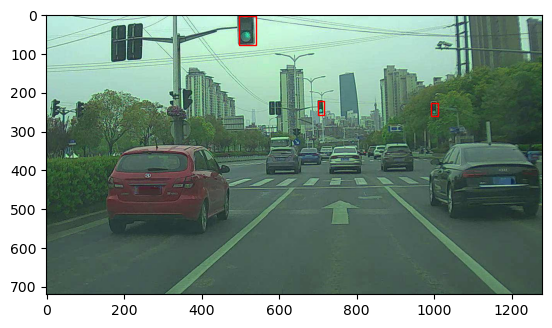

In [31]:
def addBoxes(file_name):
    path = "traffic-light-detection-and-classification/train/"
    img = plt.imread(path + "images/" + file_name + ".jpg")
    root = ET.parse(path + "labels/" + file_name + ".xml").getroot()

    _, ax = plt.subplots()
    ax.imshow(img)

    rows = 20
    boundingBoxes = getBoundingBoxes(root, rows)

    for xmin, xmax, ymin, ymax in boundingBoxes.reshape((rows, 4)):
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()
addBoxes("000003_jpg.rf.799db898a3d17b3ec8ae973342dda9e5")

In [32]:
directory = "traffic-light-detection-and-classification/train/labels/"
imgDir = "traffic-light-detection-and-classification/train/images/"

jpgNames = []
coords = []
max_lights = 0
i=0

for file in os.listdir(directory):
    
    jpgName = f"{imgDir}{file[:-4]}.jpg"
    box = getBoundingBoxes(ET.parse(directory + file).getroot())

    max_lights = max(max_lights, len(box))

    jpgNames.append(jpgName)
    coords.append(box)
    i+= 1

In [33]:
class CustomMultiBoundingBoxDataset(Dataset):
    def __init__(self, image_paths, bbox_coordinates_list, transform=None):
        self.image_paths = image_paths
        self.bbox_coordinates_list = bbox_coordinates_list
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        bbox_list = self.bbox_coordinates_list[idx]

        if self.transform:
            image = self.transform(image)

        return {'image': image, 'bboxes': bbox_list}

In [36]:
def custom_collate_fn(batch):
    images = [item['image'] for item in batch]
    bbox_lists = [item['bboxes'] for item in batch]
    images = torch.stack(images, dim=0)  # Stack images to create a 4D tensor
    return {'images': images, 'bbox_lists': bbox_lists}


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create your custom dataset
multi_bbox_dataset = CustomMultiBoundingBoxDataset(jpgNames, coords, transform=transform)

# Create a DataLoader
dataloader = DataLoader(multi_bbox_dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=custom_collate_fn)

# Iterate through the DataLoader to access images, masks, and multiple bounding box coordinates
for data in dataloader:
    images = data['images']
    bbox_lists = data['bbox_lists']

In [37]:
class SimpleBoundingBoxNetwork(nn.Module):
    def __init__(self):
        super(SimpleBoundingBoxNetwork, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 64 * 64, 256),
            nn.ReLU(),
            nn.Linear(256, 80)  # Output: x1, y1, x2, y2 coordinates
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten the features
        x = self.fc(x)
        return x

In [38]:
# Initialize your network
model = SimpleBoundingBoxNetwork()

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for bounding box regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch in dataloader:
        images = batch['images']
        bbox_lists = batch['bbox_lists']        
        # Flatten the list of bounding boxes
        bboxes = []
        for bbox_list in bbox_lists:
            for bbox in bbox_list:
                bboxes.append(bbox)
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        loss = criterion(outputs, bboxes)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Print the loss after each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 12164.7783
Epoch [2/10], Loss: 10696.7266
Epoch [3/10], Loss: 11384.3770
Epoch [4/10], Loss: 5780.5811
Epoch [5/10], Loss: 3969.8630
Epoch [6/10], Loss: 3532.6748
Epoch [7/10], Loss: 2187.2441
Epoch [8/10], Loss: 3112.4141
Epoch [9/10], Loss: 2443.9976
Epoch [10/10], Loss: 2476.3171


In [39]:
torch.save(
    model.state_dict(),
    'test_model.pt'
)



In [40]:
multi_bbox_dataset.image



In [ ]:
model.eval()
data = 